# SageMaker JumpStart - invoke text generation endpoint

This notebook demonstrates how to attach a predictor to an existing endpoint name and invoke the endpoint with example payloads.

In [1]:
from sagemaker.predictor import retrieve_default

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


Retrieve a predictor from your deployed endpoint name.

In [2]:
endpoint_name = "jumpstart-dft-hf-llm-yi-1-5-9b-chat-20240527-022751"
predictor = retrieve_default(endpoint_name)

Now query your endpoint with example payloads.

In [3]:
payload = {
    "inputs": "You are a helpful assistant.<|im_start|>user\nWho won the world series in 2020?<|im_end|>\n<|im_start|>assistant\n",
    "parameters": {
        "max_new_tokens": 256
    }
}
response = predictor.predict(payload)
print(response)

[{'generated_text': 'You are a helpful assistant.<|im_start|>user\nWho won the world series in 2020?<|im_end|>\n<|im_start|>assistant\nThe Los Angeles Dodgers won the 2020 World Series. They defeated the Tampa Bay Rays in a best-of-seven series, clinching the championship in Game 6. This World Series was unique due to the COVID-19 pandemic, which led to an abbreviated 60-game regular season and the first virtual championship ceremony.'}]


This model supports the following payload parameters. You may specify any subset of these parameters when invoking an endpoint.

* **do_sample:** If True, activates logits sampling. If specified, it must be boolean.
* **max_new_tokens:** Maximum number of generated tokens. If specified, it must be a positive integer.
* **repetition_penalty:** A penalty for repetitive generated text. 1.0 means no penalty.
* **return_full_text:** If True, input text will be part of the output generated text. If specified, it must be boolean. The default value for it is False.
* **stop**: If specified, it must a list of strings. Text generation stops if any one of the specified strings is generated.
* **seed**: Random sampling seed.
* **temperature:** Controls the randomness in the output. Higher temperature results in output sequence with low-probability words and lower temperature results in output sequence with high-probability words. If `temperature` -> 0, it results in greedy decoding. If specified, it must be a positive float.
* **top_k:** In each step of text generation, sample from only the `top_k` most likely words. If specified, it must be a positive integer.
* **top_p:** In each step of text generation, sample from the smallest possible set of words with cumulative probability `top_p`. If specified, it must be a float between 0 and 1.
* **truncate:** Truncate inputs tokens to the given size.
* **typical_p:** Typical decoding mass, according to [Typical Decoding for Natural Language Generation](https://arxiv.org/abs/2202.00666).
* **best_of:** Generate best_of sequences and return the one if the highest token logprobs.
* **watermark:** Whether to perform watermarking with [A Watermark for Large Language Models](https://arxiv.org/abs/2301.10226).
* **details:** Return generation details, to include output token logprobs and IDs.
* **decoder_input_details:** Return decoder input token logprobs and IDs.
* **top_n_tokens:** Return the N most likely tokens at each step.

In [4]:
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.config import RunnableConfig

In [5]:
text1 = \
"""你是一名小说家，热衷于创意写作和编写故事。 
请帮我编写一个故事，对象是10-12岁的小学生
故事背景：
讲述一位名叫莉拉的年轻女子发现自己有控制天气的能力。她住在一个小镇上，每个人都互相认识。
其他要求：
-避免暴力，色情，粗俗的语言
-长度要求不少于500字
请开始：
"""

In [45]:
endpoint_name = "jumpstart-dft-hf-llm-yi-1-5-9b-chat-20240527-022751"
predictor = retrieve_default(endpoint_name)
max_new_tokens = 100
text = "Who won the world series in 2020?"
def invoke_sagemaker(prompt,max_new_tokens):
    # print('----start----')
    parameters = {
            "max_new_tokens":max_new_tokens, 
            "do_sample": True,
            "temperature": 0.7,
            "top_p": 0.8,
            "top_k": 250
        }
    payload = {
        "inputs": f"You are a helpful assistant.<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n",
        **parameters
    }

    response = predictor.predict( payload )
    return response

In [46]:
invoke_sagemaker(text,max_new_tokens)

[{'generated_text': 'You are a helpful assistant.<|im_start|>user\nWho won the world series in 2020?<|im_end|>\n<|im_start|>assistant\nThe Los Angeles Dodgers won the 2020 World Series, securing a 3-2 victory against the Tampa Bay Rays. This World Series was unique due to the COVID-19 pandemic, as it was the only one played without any fans in the stadiums.'}]

In [47]:
chain = RunnableLambda(invoke_sagemaker).bind(max_new_tokens=max_new_tokens)

# 测试并发性能

In [48]:
import time

In [49]:
concurrent = [1,5,10,15,20,25]

In [50]:
config = RunnableConfig(max_concurrency=max(concurrent))

In [51]:
results = []

In [52]:
for n in concurrent:
    time1 = time.time()
    chain.batch([text1]*n,config=config)
    cost = time.time()-time1
    results.append([n,cost,max_new_tokens/cost,n*max_new_tokens/cost])
    print(f'concurrent users:{n}, time cost:{cost:.2f},tokens/s:{max_new_tokens/cost:.2f},total throughput:{n*max_new_tokens/cost:.2f}')

concurrent users:1, time cost:3.94,tokens/s:25.40,total throughput:25.40
concurrent users:5, time cost:6.65,tokens/s:15.04,total throughput:75.20
concurrent users:10, time cost:10.81,tokens/s:9.25,total throughput:92.55
concurrent users:15, time cost:15.01,tokens/s:6.66,total throughput:99.94
concurrent users:20, time cost:19.21,tokens/s:5.20,total throughput:104.09
concurrent users:25, time cost:23.42,tokens/s:4.27,total throughput:106.74


In [60]:
results

[[1, 3.937725067138672, 25.39537379958944, 25.39537379958944],
 [5, 6.649196624755859, 15.039410870733835, 75.19705435366917],
 [10, 10.805256843566895, 9.254754555837959, 92.54754555837958],
 [15, 15.009580373764038, 6.66241144054865, 99.93617160822974],
 [20, 19.214237928390503, 5.2044739100603294, 104.08947820120659],
 [25, 23.421430110931396, 4.269594107890422, 106.73985269726055]]

In [61]:
import matplotlib.pyplot as plt

In [62]:
# 从二维数组中提取列
x = [row[0] for row in results]  # 第一列
y1 = [row[1] for row in results]  # 第二列
y2 = [row[2] for row in results]  # 第三列
y3 = [row[3] for row in results]  # 第四列

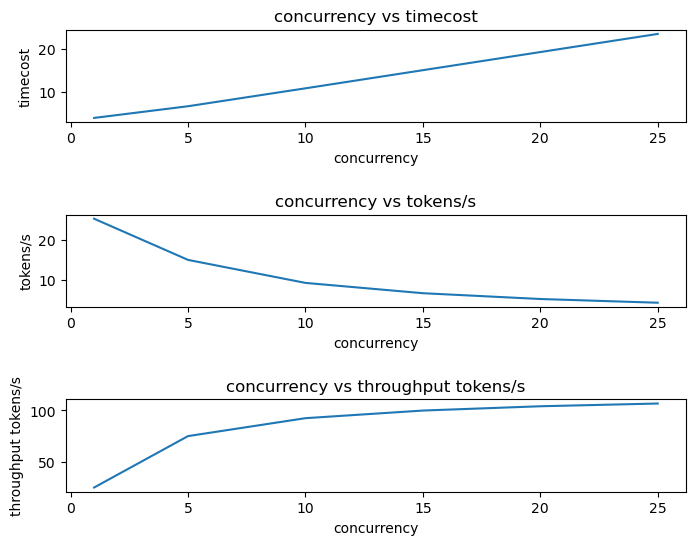

In [66]:
# 创建图形
fig, axs = plt.subplots(3, 1, figsize=(8, 6))

# 绘制第一列与第二列的关系
axs[0].plot(x, y1)
axs[0].set_title('concurrency vs timecost')
axs[0].set_xlabel('concurrency')
axs[0].set_ylabel('timecost')

# 绘制第一列与第三列的关系
axs[1].plot(x, y2)
axs[1].set_title('concurrency vs tokens/s')
axs[1].set_xlabel('concurrency')
axs[1].set_ylabel('tokens/s')

# 绘制第一列与第四列的关系
axs[2].plot(x, y3)
axs[2].set_title('concurrency vs throughput tokens/s')
axs[2].set_xlabel('concurrency')
axs[2].set_ylabel('throughput tokens/s')

# 调整子图之间的间距
plt.subplots_adjust(hspace=1)

# 显示图形
plt.show()